# Particle Swarm Optimization (PSO)

Thanks to the work by Lillian Weng, Ayden Salazar, Xingli Yu, Topiltzin Hernandes, Joanna Yoo, and Elijah Bartolome; [MGSurvE](https://github.com/Chipdelmal/MGSurvE) also contains a beta implementation of a PSO algorithm as an alternative to the base GA. This is a more advanced optimization topic, so we will just go through the basics in this demo but have a look at the ["More Information"](#more-information) section for additional resources.

In [1]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
# Load libraries --------------------------------------------------------------
from os import path
import numpy as np
import pandas as pd
import MGSurvE as srv
from math import sqrt, inf
import matplotlib.pyplot as plt
# Setup data path and ID ------------------------------------------------------
(ID, LND_TOP, OUT_PTH) = ('pso', 'Uniform', './out/')
srv.makeFolder(OUT_PTH)

This time we will allow the setup of three different types of synthetic landscapes:
* `"Grid"`: A regular grid of points laid across a rectangular setup.
* `"Uniform"`: A sample of points uniformly sampled from a rectangular set of coordinates.
* `"Ring"`: A random sample of points laid along a ring with an iner and outer radius.

In [2]:
PTS_NUM = 100
RADII = (425, 500)
BBOX = ((-500, 500), (-350, 350))
# Generate Synthetic Pointset -------------------------------------------------
if LND_TOP == 'Grid':
    (ptsNum, ptsTypes) = (int(sqrt(PTS_NUM)), 1)
    xy = srv.ptsRegularGrid(PTS_NUM, (BBOX[0], BBOX[0])).T
elif LND_TOP == 'Uniform':
    (ptsNum, ptsTypes) = (PTS_NUM, 1)
    xy = srv.ptsRandUniform(ptsNum, BBOX).T
elif LND_TOP == 'Ring':
    (ptsNum, radii, ptsTypes) = (PTS_NUM, RADII, 1)
    xy = srv.ptsDonut(ptsNum, radii).T
pType = np.random.choice(ptsTypes, xy.shape[1])
points = pd.DataFrame({'x': xy[0], 'y': xy[1], 't': pType})
mKer = {'params': [.075, 1.0e-10, inf], 'zeroInflation': .75}

And optimize five traps with two different exponentially-decaying attractiveness kernels:

In [3]:
# Traps -----------------------------------------------------------------------
traps = pd.DataFrame({
    'x': [0, 0, 0, 0, 0], 
    'y': [0, 0, 0, 0, 0],
    't': [0, 1, 0, 1, 0], 
    'f': [0, 0, 0, 0, 0]
})
tKer = {
    0: {'kernel': srv.exponentialDecay, 'params': {'A': .75, 'b': .025}},
    1: {'kernel': srv.exponentialDecay, 'params': {'A': .50, 'b': .015}}
}
# Landscape -------------------------------------------------------------------
lnd = srv.Landscape(
    points, 
    kernelParams=mKer,
    traps=traps, trapsKernels=tKer
)
bbox = lnd.getBoundingBox()

PSO base algorithms have three main meta-parameters: number of particles, speed and acceleration constants ($\phi$); please have a look at our [documentation](https://chipdelmal.github.io/MGSurvE/build/html/PSO.html) for more information on how to parametrize them. Once we have setup our landscape and values for the PSO, we can run the algorithm in a very similar way as we did our GA:

In [4]:
GENS = 400
# PSO -------------------------------------------------------------------------
(GENS, PARTS, SPD, PHI) = (
    GENS, traps.shape[0]*20,
    (-max(max(bbox))/30, max(max(bbox))/30),
    (max(max(bbox))/15, max(max(bbox))/15)
)
pso = srv.Particle_Swarm(
    lnd=lnd, traps=traps,
    num_particles=PARTS, num_gens=GENS, 
    p_min=min(bbox[0][0], bbox[1][0]), p_max=max(bbox[1][0], bbox[1][1]),  
    s_min=SPD[0], s_max=SPD[1],
    phi1=PHI[0], phi2=PHI[1],
    optimFunctionArgs={'inner': np.sum, 'outer': np.max}
)
(pop, logbook, _) = pso.evaluate()
best = list(logbook[logbook['min']==min(logbook['min'])]['traps'])[0]
bestTraps = np.reshape(best, (-1, 2))
lnd.updateTrapsCoords(bestTraps)

gen	evals	min   	avg    	max    	std    	best	traps                                                                                                                                                                                                      
0  	100  	156.17	2316.77	12280.7	2236.63	70  	[-184.36463275002333, -173.85829453647236, -189.67800423069664, 115.6257131320178, -308.365251168126, -308.3526589734096, 211.2576393261904, -50.112828304280846, -239.20576896015967, -234.10460737052102]
1  	100  	145.746	2240.51	12192.2	2140.86	70  	[-188.3293136441542, -179.0946745072524, -191.66209575644717, 120.37600255284497, -317.65393181560756, -314.3943940832017, 216.66009874763978, -58.57639767393016, -246.42974650950867, -224.47642243260174]
2  	100  	140.745	2154.27	12011.6	2056.6 	70  	[-192.2939945382851, -184.33105447803243, -193.6461872821977, 125.12629197367214, -326.9426124630891, -320.4361291929938, 222.06255816908916, -67.03996704357948, -253.65372405885768, -214.8482374946824

And saving the results is exactly the same as we have done before!

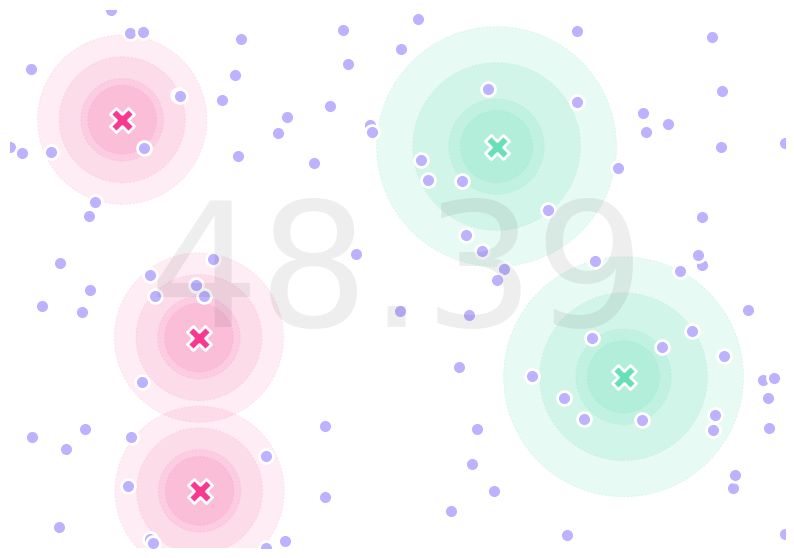

In [5]:
# Export Results --------------------------------------------------------------
dta = pd.DataFrame(logbook)
srv.dumpLandscape(lnd, OUT_PTH, '{}_{}-TRP'.format(ID, LND_TOP), fExt='pkl')
srv.exportLog(logbook, OUT_PTH, '{}_{}-LOG'.format(ID, LND_TOP))
# Plot Results ----------------------------------------------------------------
(fig, ax) = plt.subplots(1, 1, figsize=(10, 10), sharey=False)
lnd.plotSites(fig, ax, size=100)
# lnd.plotMigrationNetwork(fig, ax, alphaMin=.6, lineWidth=25)
lnd.plotTraps(fig, ax)
srv.plotFitness(fig, ax, min(logbook['min']), zorder=30)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    path.join(OUT_PTH, '{}_{}-TRP.png'.format(ID, LND_TOP)),
    facecolor='w', bbox_inches='tight', 
    pad_inches=0, dpi=300
)

<hr>

# More Information

* [MGSurvE's PSO Demo](https://chipdelmal.github.io/MGSurvE/build/html/PSO.html)
* [Hana Rhim's PSO Introduction](https://www.baeldung.com/cs/pso)